In [ ]:
!pip install transformers
!pip install torch
!pip install datasets

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
mydir = "/content/drive/MyDrive/Dataset/"

##First thing I created the dataset for the fine-tuning
###For that I used the dataset with the recipes and the preparation steps and the dataset with the ratings

In [ ]:
step = pd.read_csv(mydir + "RAW_recipes.csv")
rew = pd.read_csv(mydir + "RAW_interactions.csv")

In [ ]:
rew = rew.drop(columns=['user_id', 'date', 'review'])
step = step.drop(columns=['name', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'description', 'n_ingredients'])
df = step[:200000]

In [ ]:
final = df
final.insert(3, "rating", 0)
len(final)

200000

In [ ]:
#Here I matched the id of every recipe to the ratings dataset and I associated the mean of the ratings
for index in df["id"]:
  sum = 0
  count = 0
  for rating in rew[rew["recipe_id"]==index]["rating"]:
    sum += rating
    count += 1
  if(count>0):
    final.loc[final["id"]==index, 'rating'] = float(sum/count)

In [ ]:
final.to_csv("mydir + "finetuning.csv")

In [ ]:
def is_valid_sentence(i):
  if( (i[0]==" ") or (i[1]==" ") or i[0]=="," or i[0]=='"' or i[1]=='"' or i[0]==":" or i[0]=="-" or i[-1]=="-" or i[-1]==" "):
    return False
  return '?' not in i and '!' not in i and '~' not in i

In [ ]:
#This is to drop the rows with noisy sentences
#The extra variable is to check the operation
start = 0
end = 170000
dropped = 0
modified = 0
for i in range(start, end):
  print("Actual: ", i, " Dropped: ", dropped, " Modified: ", modified)
  x = final.loc[i]["steps"]
  lista = x[1:-2].split("', ")
  newList = []
  isOk = True
  for s in lista:
    z = len(s.split(" "))
    if(z<=1 or z>=30):
      isOk = False
      break
    if(not is_valid_sentence(s)):
      isOk = False
      break
    newList.append(s[1:])
  if(isOk == True):
    a = "; ".join(newList)              #Every step is separated with the separator ';'
    final.loc[i, "steps"] = a
    modified += 1
  else:
    final = final.drop(index=i)
    dropped += 1

In [ ]:
final.to_csv(mydir + "intermedio.csv")
final = pd.read_csv(mydir + "intermedio.csv")

In [ ]:
final = final.drop(columns=["index"])
final = final.reset_index()

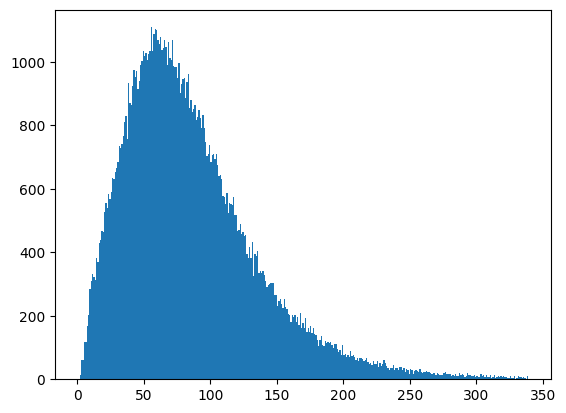

In [ ]:
#Plot the length of the sentences
import matplotlib.pyplot as plt

a = []
for i in range(0, len(final)):
  z = len(final.loc[i]["steps"].replace(',', '').split(" "))
  a.append(z)

plt.hist(a,  bins=range(0, 340))
plt.show()

In [ ]:
#I dropped the rows with sentences with length > 200 word
for i in range(0, len(final)):
  z = len(final.loc[i]["steps"].replace(',', '').split(" "))
  if(z>200):
    final = final.drop(i)

In [ ]:
len(final)

106913

In [ ]:
#Normalization of the ratings in order to get a rating with value between 0 and 1
final["rating"] = final["rating"] / 5

In [ ]:
final['ingredients'] = 'Ingredients: ' + final['ingredients']

In [ ]:
final = final.drop(columns=["index"])

In [ ]:
for i in range(0, len(final)):
  z = final.loc[i]["ingredients"][2:-2].split("', '")
  final.loc[i, 'ingredients'] = ", ".join(z)

In [ ]:
final.head()

,id,steps,ingredients,rating
0,137739,make a choice and proceed with recipe; dependi...,"Ingredients: winter squash, mexican seasoning,...",1.0
1,31490,preheat oven to 425 degrees f; press dough int...,"Ingredients: prepared pizza crust, sausage pat...",0.7
2,112140,brown ground beef in large pot; add chopped on...,"Ingredients: ground beef, yellow onions, diced...",0.8
3,5289,combine ingredients in blender; cover and blen...,"Ingredients: milk, vanilla ice cream, frozen a...",1.0
4,25274,toast the fennel seeds and lightly crush them;...,"Ingredients: fennel seeds, green olives, ripe ...",0.4


##Now the fine-tuning task

In [ ]:
model_dir = mydir + "T5_FineTuning"

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

#The first time the loaded model was the model trained with MLM
model_name = "moro01525/T5_FineTuning"
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
from datasets import Dataset
final[:100000] = final[:100000].sample(frac=1).reset_index(drop=True)
dataset = Dataset.from_pandas(final[:33000])
evaluation = Dataset.from_pandas(final[101000:106000])
test = final[100000:101000]

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples['ingredients'], max_length=64, truncation=True, padding='max_length')
    labels = tokenizer(examples['steps'], max_length=256, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    model_inputs['rating'] = examples['rating']
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_evaluation = evaluation.map(preprocess_function, batched=True)

In [ ]:
from transformers import Trainer

#A special Trainer class to compute the weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        ratings = inputs.pop("rating")

        outputs = model(**inputs)
        logits = outputs.logits

        # Calculate the standard loss with cross entropy
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))

        if ratings is not None:
            ratings = ratings.view(-1).float()
            for i in range(0, len(ratings)):
              rate = ratings[i]
              if(rate == 0):                      #This is to consider also the row with 0 rating, in order to get at least some information
                ratings[i] = 0.1
            weighted_loss = loss * ratings        #The loss is weighted with the ratings
            loss = weighted_loss.mean()

        return (loss, outputs) if return_outputs else loss

    #Below I changed the dataloader to use my data collator

    def get_train_dataloader(self):
        dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            collate_fn=self.data_collator,
            sampler=self._get_train_sampler(),
            drop_last=self.args.dataloader_drop_last,
        )
        return dataloader

    def get_eval_dataloader(self, eval_dataset=None):
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        dataloader = DataLoader(
            eval_dataset,
            batch_size=self.args.per_device_eval_batch_size,
            collate_fn=self.data_collator,
            sampler=self._get_eval_sampler(eval_dataset),
            drop_last=self.args.dataloader_drop_last,
        )
        return dataloader

In [ ]:
model_dir = mydir + "T5_FineTuning"

In [ ]:
from torch.utils.data import DataLoader

#The definition of data collator
def collate_fn(batch):

    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    ratings = [item['rating'] for item in batch]

    input_ids = torch.tensor(input_ids, dtype=torch.long)
    attention_mask = torch.tensor(attention_mask, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    ratings = torch.tensor(ratings, dtype=torch.float32)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels, 'rating': ratings}

In [ ]:
from transformers import TrainingArguments
from transformers import DataCollatorForSeq2Seq

#Define the training arguments
training_args = TrainingArguments(
    output_dir=model_dir,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=4,
    seed=55,
    save_steps=10_000,
    save_total_limit=2,
    eval_strategy="steps",
    eval_steps=1500,
    logging_steps=1000
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_evaluation,
    data_collator=collate_fn,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(model_dir)

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub(commit_message='T5 addestrato nella generazione di ricette dopo 5 epoch')

##Below the analysis of the model and the metrics

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained(model_dir)

In [ ]:
def generate_recipe(model, ingredients):
    input_text = f"Ingredients: {ingredients}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    outputs = model.generate(input_ids, max_length=150, num_beams=5, repetition_penalty=2.5, no_repeat_ngram_size=2, early_stopping=True)
    recipe = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return recipe

In [ ]:
#Print some examples

import random
for i in range(0, 2):
  index = random.randint(0, 1000) + 100000
  input = test.loc[index]["ingredients"]
  output = test.loc[index]["steps"]
  predict = generate_recipe(model, input)

  print(input, "\n")
  print(predict, "\n")
  print(output, "\n------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")

In [ ]:
!pip install sentence_transformers

In [ ]:
import random
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

#This is a Sentence-BERT model for word embedding (sentence in this case) to check the similairty between the model generation and the expected sentence
modelForSimilarity = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#I compute the metric on 200 random rows from test dataset
total = 0
len = 200
for i in range(0, len):
  index = random.randint(0, 999) + 100000
  input = test.loc[index]["ingredients"]
  generated_text = generate_recipe(input)
  reference_text = test.loc[index]["steps"]

  embeddings_generated = modelForSimilarity.encode([generated_text])
  embeddings_reference = modelForSimilarity.encode([reference_text])

  similarity = cosine_similarity(embeddings_generated, embeddings_reference)
  total += similarity[0][0]
print(total/len)

In [ ]:
!pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer

total = {
  "rouge1": 0,
  "rouge2": 0,
  "rougeL": 0
}

#I compute the metric on 200 random rows from test dataset
len = 200
for i in range(0, len):
  index = random.randint(0, 999) + 100000

  input = test.loc[index]["ingredients"]
  generated_text = generate_recipe(input)
  reference_text = test.loc[index]["steps"]

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(reference_text, generated_text)

  for j in scores:
    total[j] += scores[j].fmeasure

  for j in total:
  print(j, ": ", total[j]/len)